# Jigsaw - Agile Community Rules Classification
### https://www.kaggle.com/competitions/jigsaw-agile-community-rules

## Constrained Generation for Reddit Content Moderation: Binary Classification Using Logit Probabilities
Technical Overview
This notebook implements a constrained generation approach for automated content moderation using a Llama 3.2-1B model. Instead of relying on traditional text parsing, we employ logits processors to restrict the model's output vocabulary to only "True" and "False" tokens, then extract probabilistic confidence scores directly from the model's logit distributions.
A reference notebook from  https://www.kaggle.com/code/xbar19/jigsaw-llama3-1-8b-instruct-fine-tuned is appreciated.

## Install packages on Kaggle: Add-ons > Install Dependencies 

```bash
pip install pip3-autoremove
pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
pip install unsloth vllm
pip install scikit-learn
```

In [1]:
import kagglehub
import pandas as pd
import os
import glob
import pandas as pd

# Your path and files
base_path = "./data/final/"
files = ["df_test_0.csv"]  # Put your file names here

# Load and combine
dfs = [pd.read_csv(f"{base_path}{file}") for file in files]
df_test = pd.concat(dfs, ignore_index=True)
df_test['violates_rule_yn'] = df_test['violates_rule'].map({True: "Yes", False: "No"})
print(f"Combined shape: {df_test.shape}")

df_test.head(5)

df_test=df_test[:100]

Combined shape: (2029, 12)


## Load LLM (llama-3.2-1B) model with vLLM (Suitable for batch inference) (logits output)

In [2]:
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
import os
os.environ['VLLM_USE_V1'] = '0'  # Force V0 for logits processor support

import torch
import numpy as np
import pandas as pd
from vllm import LLM, SamplingParams
from transformers import LogitsProcessor
import math
from vllm.lora.request import LoRARequest


class YesNoLogitsProcessor(LogitsProcessor):
    """Forces model to only output Yes or No tokens"""
    def __init__(self, allowed_ids):
        self.allowed_ids = allowed_ids
        
    def __call__(self, input_ids, scores: torch.Tensor) -> torch.Tensor:
        # Create a mask that's -inf for all tokens except allowed ones
        mask = torch.full_like(scores, float('-inf'))
        mask[self.allowed_ids] = 0
        
        # Apply the mask to force only allowed tokens
        scores = scores + mask
        return scores



class LlamaClassifier:
    def __init__(self):
        # Model path selection
        if os.getenv('KAGGLE_KERNEL_RUN_TYPE'):
            self.model_path = "/kaggle/input/qwen2.5/transformers/14b-instruct-gptq-int4/1--"
        else:
            self.model_path = "unsloth/Qwen2.5-3B-Instruct"
        
        # Initialize model with LoRA support
        self.model = LLM(
            model=self.model_path,
            #quantization='gptq',
            max_model_len=2048,
            tensor_parallel_size=1,
            gpu_memory_utilization=0.99,
            seed=123,
            trust_remote_code=True,
            dtype="half",
            enforce_eager=True,
            disable_log_stats=True,
            enable_prefix_caching=True,
            enable_lora=True,
            max_lora_rank=64
        )
        
        
        self.tokenizer = self.model.get_tokenizer()
        self.setup_token_constraints()
        
        # Sampling with constrained output - try more balanced parameters
        logits_processors = [YesNoLogitsProcessor(self.KEEP)]
        self.sampling_params = SamplingParams(
            n=1,
            temperature=0.0,  # Lower temperature for more deterministic
            seed=777,
            skip_special_tokens=True,
            max_tokens=1,
            logits_processors=logits_processors,
            logprobs=2
        )
        
        # Sampling WITHOUT constraints - to see all token probabilities
        self.sampling_params_unconstrained = SamplingParams(
            n=1,
            temperature=0.0,
            seed=777,
            skip_special_tokens=True,
            max_tokens=1,
            logprobs=20  # Get top 20 token probabilities
        )
    
    def setup_token_constraints(self):
        """Get token IDs for 'No' and 'Yes'"""
        choices = ["No", "Yes"]
        self.KEEP = []
        for x in choices:
            c = self.tokenizer.encode(x, add_special_tokens=False)[0]
            self.KEEP.append(c)
        
        self.no_token_id = self.KEEP[0]
        self.yes_token_id = self.KEEP[1]
        print(f"Constrained to tokens: {self.KEEP} = {choices}")
        print(f"No token: {self.no_token_id}, Yes token: {self.yes_token_id}")

    def create_lora_request(self, lora_adapter_path, adapter_name="custom_adapter"):
        """Create LoRA request object"""
        return LoRARequest(
            lora_name=adapter_name,
            lora_int_id=1,
            lora_local_path=lora_adapter_path
        )
    
    def create_prompt(self, input_data: pd.Series):
        # Create system message
        system_msg = (
            f"You are an expert moderator for /r/{input_data['subreddit']}. "
            "Your task is to determine if a comment violates the rule. "
            "Answer strictly with *Yes* or *No*."
        )

        # User message: structured, concise, and clearly separated examples
        user_msg = (
            f"Rule: {input_data['rule']}\n\n"
            f"Examples of violations:\n"
            f"1. {input_data['positive_example_1']} -> Yes\n"
            f"2. {input_data['positive_example_2']} -> Yes\n\n"
            f"Examples of non-violations:\n"
            f"1. {input_data['negative_example_1']} -> No\n"
            f"2. {input_data['negative_example_2']} -> No\n\n"
            f"Now, decide if the following test comment violates the rule:\n"
            f" Test Comment: {input_data['test_comment']}"
        )
        
        # Create messages list for chat template (same format as training)
        messages = [
            {"role": "system", "content": system_msg},
            {"role": "user", "content": user_msg}
        ]
        
        # Use tokenizer chat template with generation prompt for inference
        formatted_prompt = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True  # This adds the assistant prompt for generation
        )
        
        return formatted_prompt
    
    def analyze_token_probabilities(self, input_data: pd.Series, lora_adapter_path=None, top_k=20):
        """Analyze top-k token probabilities WITHOUT constraints"""
        prompt = self.create_prompt(input_data)
        
        # Add LoRA request if path provided
        generate_kwargs = {"use_tqdm": False}
        if lora_adapter_path:
            generate_kwargs["lora_request"] = self.create_lora_request(lora_adapter_path)
        
        responses = self.model.generate([prompt], self.sampling_params_unconstrained, **generate_kwargs)
        
        response = responses[0]
        predicted_text = response.outputs[0].text.strip()
        
        print("=" * 80)
        print(f"Predicted token: '{predicted_text}'")
        print("=" * 80)
        
        # Get logprobs for the first token
        logprobs_dict = response.outputs[0].logprobs[0]
        
        # Sort by probability (descending)
        token_probs = []
        for token_id, logprob_obj in logprobs_dict.items():
            prob = math.exp(logprob_obj.logprob)
            decoded = logprob_obj.decoded_token
            token_probs.append({
                'token_id': token_id,
                'token': decoded,
                'probability': prob,
                'logprob': logprob_obj.logprob
            })
        
        # Sort by probability descending
        token_probs.sort(key=lambda x: x['probability'], reverse=True)
        
        print(f"\nTop {min(top_k, len(token_probs))} Token Probabilities:")
        print("-" * 80)
        print(f"{'Rank':<6} {'Token':<20} {'Token ID':<12} {'Probability':<15} {'LogProb':<12}")
        print("-" * 80)
        
        for i, tp in enumerate(token_probs[:top_k], 1):
            print(f"{i:<6} {repr(tp['token']):<20} {tp['token_id']:<12} {tp['probability']:<15.6f} {tp['logprob']:<12.4f}")
        
        # Highlight Yes/No tokens
        print("\n" + "=" * 80)
        print("Yes/No Token Analysis:")
        print("-" * 80)
        
        yes_info = next((tp for tp in token_probs if tp['token_id'] == self.yes_token_id), None)
        no_info = next((tp for tp in token_probs if tp['token_id'] == self.no_token_id), None)
        
        if yes_info:
            yes_rank = next(i for i, tp in enumerate(token_probs, 1) if tp['token_id'] == self.yes_token_id)
            print(f"'Yes' token (ID: {self.yes_token_id}): Rank #{yes_rank}, Prob = {yes_info['probability']:.6f}")
        else:
            print(f"'Yes' token (ID: {self.yes_token_id}): Not in top {top_k}")
            
        if no_info:
            no_rank = next(i for i, tp in enumerate(token_probs, 1) if tp['token_id'] == self.no_token_id)
            print(f"'No' token (ID: {self.no_token_id}): Rank #{no_rank}, Prob = {no_info['probability']:.6f}")
        else:
            print(f"'No' token (ID: {self.no_token_id}): Not in top {top_k}")
        
        print("=" * 80)
        
        return {
            'predicted_text': predicted_text,
            'top_tokens': token_probs[:top_k],
            'yes_info': yes_info,
            'no_info': no_info
        }
    
    def predict_classification(self, input_data: pd.Series, lora_adapter_path=None):
        """Single prediction with optional LoRA"""
        prompt = self.create_prompt(input_data)
        
        # Add LoRA request if path provided
        generate_kwargs = {"use_tqdm": False}
        if lora_adapter_path:
            generate_kwargs["lora_request"] = self.create_lora_request(lora_adapter_path)
        
        responses = self.model.generate([prompt], self.sampling_params, **generate_kwargs)
        
        response = responses[0]
        print("Debug response:", response)
        
        predicted_text = response.outputs[0].text.strip()
        
        try:
            x = response.outputs[0].logprobs[0]
            print("Debug logprobs:", x)
            
            # Extract probabilities for No/Yes tokens
            logprobs = []
            for k in self.KEEP:
                if k in x:
                    logprobs.append(math.exp(x[k].logprob))
                else:
                    logprobs.append(0)
            
            logprobs = np.array(logprobs)
            #logprobs /= (logprobs.sum() + 1e-15)
            
            print(f"Debug: Raw logprobs: {logprobs}, No prob: {logprobs[0]}, Yes prob: {logprobs[1]}")
            
            violation_probability = logprobs[1]  # Yes probability
            confidence = max(logprobs)
            
        except Exception as e:
            print(f"Error: {e}")
            violation_probability = 0.5
            confidence = 0.5
        
        return {
            'prediction': predicted_text,
            'is_violation': violation_probability > 0.5,
            'violation_probability': violation_probability,
            'confidence': confidence
        }
    
    def predict_batch(self, input_data_list, verbose=False, lora_adapter_path=None):
        """Batch predictions with optional LoRA"""
        prompts = [self.create_prompt(data) for data in input_data_list]
        
        # Add LoRA request if path provided
        generate_kwargs = {"use_tqdm": True}
        if lora_adapter_path:
            generate_kwargs["lora_request"] = self.create_lora_request(lora_adapter_path)
        
        responses = self.model.generate(prompts, self.sampling_params, **generate_kwargs)
        
        results = []
        for i, response in enumerate(responses):
            try:
                predicted_text = response.outputs[0].text.strip()
                x = response.outputs[0].logprobs[0]
                
                # Extract probabilities
                logprobs = []
                for k in self.KEEP:
                    if k in x:
                        logprobs.append(math.exp(x[k].logprob))
                    else:
                        logprobs.append(0)
                
                logprobs = np.array(logprobs)
                #logprobs /= (logprobs.sum() + 1e-15)
                
                violation_probability = logprobs[1]  # Yes probability
                confidence = max(logprobs)
                
            except Exception as e:
                print(f"Error {i}: {e}")
                violation_probability = 0.5
                confidence = 0.5
                predicted_text = "Error"
            
            result = {
                'prediction': predicted_text,
                'is_violation': violation_probability > 0.5,
                'violation_probability': violation_probability,
                'confidence': confidence,
                'sample_index': i
            }
            
            results.append(result)
        
        return results

    # Convenience methods for LoRA usage
    def predict_with_lora(self, input_data: pd.Series, lora_adapter_path):
        """Single prediction using LoRA adapter"""
        return self.predict_classification(input_data, lora_adapter_path)
    
    def predict_batch_with_lora(self, input_data_list, lora_adapter_path, verbose=False):
        """Batch predictions using LoRA adapter"""
        return self.predict_batch(input_data_list, verbose, lora_adapter_path)

INFO 10-05 12:40:11 [__init__.py:235] Automatically detected platform cuda.


## Instantiate the model=vLLM

In [3]:
model=LlamaClassifier()

WARNING 10-05 12:40:19 [config.py:3443] Casting torch.bfloat16 to torch.float16.
INFO 10-05 12:40:19 [config.py:1604] Using max model len 2048
WARNING 10-05 12:40:19 [cuda.py:103] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 10-05 12:40:19 [llm_engine.py:228] Initializing a V0 LLM engine (v0.10.0) with config: model='unsloth/Qwen2.5-3B-Instruct', speculative_config=None, tokenizer='unsloth/Qwen2.5-3B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=Fal

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 10-05 12:40:25 [default_loader.py:262] Loading weights took 2.00 seconds
INFO 10-05 12:40:25 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 10-05 12:40:25 [model_runner.py:1115] Model loading took 6.0371 GiB and 3.433274 seconds
INFO 10-05 12:40:27 [worker.py:295] Memory profiling takes 1.26 seconds
INFO 10-05 12:40:27 [worker.py:295] the current vLLM instance can use total_gpu_memory (15.69GiB) x gpu_memory_utilization (0.99) = 15.54GiB
INFO 10-05 12:40:27 [worker.py:295] model weights take 6.04GiB; non_torch_memory takes 0.05GiB; PyTorch activation peak memory takes 1.39GiB; the rest of the memory reserved for KV Cache is 8.05GiB.
INFO 10-05 12:40:27 [executor_base.py:113] # cuda blocks: 14662, # CPU blocks: 7281
INFO 10-05 12:40:27 [executor_base.py:118] Maximum concurrency for 2048 tokens per request: 114.55x
INFO 10-05 12:40:28 [llm_engine.py:424] init engine (profile, create kv cache, warmup model) took 3.08 seconds
Constrained to tokens: [2753, 9454] = ['No', 'Yes']
N

## Single Prediction Analysis - View Top 20 Token Probabilities

In [4]:
# Select a sample to analyze
sample_idx = 0  # Change this to analyze different samples
sample = df_test.iloc[sample_idx]

print("Sample Information:")
print(f"Subreddit: {sample['subreddit']}")
print(f"Rule: {sample['rule']}")
print(f"Test Comment: {sample['test_comment']}")
print(f"Ground Truth: {sample['violates_rule']}")
print()

# Analyze with LoRA
lora_path = "./lora/Qwen25_3B_Instruct_unsloth_lora_fp16_r64_a64_s15148_e_2_msl2048-0-cr12-qcr12345"
result = model.analyze_token_probabilities(sample, lora_adapter_path=lora_path, top_k=20)

Sample Information:
Subreddit: Futurology
Rule: No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.
Test Comment: Banks don't want you to know this! Click here to know more!
Ground Truth: False



/tmp/ipykernel_24438/909928544.py:97: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  return LoRARequest(


Predicted token: 'No'

Top 20 Token Probabilities:
--------------------------------------------------------------------------------
Rank   Token                Token ID     Probability     LogProb     
--------------------------------------------------------------------------------
1      'No'                 2753         0.787174        -0.2393     
2      'Yes'                9454         0.211865        -1.5518     
3      'Link'               3939         0.000081        -9.4268     
4      'Sure'               39814        0.000052        -9.8565     
5      'Not'                2623         0.000050        -9.9034     
6      'None'               4064         0.000038        -10.1768    
7      'Maybe'              21390        0.000031        -10.3877    
8      ' No'                2308         0.000026        -10.5752    
9      'Nos'                85092        0.000025        -10.5909    
10     'NO'                 8996         0.000023        -10.6768    
11     'YES'     

## Compare: Without LoRA vs With LoRA

In [12]:
# Analyze WITHOUT LoRA
print("\n\n" + "#" * 80)
print("# WITHOUT LoRA - Base Model")
print("#" * 80 + "\n")
result_base = model.analyze_token_probabilities(sample, lora_adapter_path=None, top_k=2)

print("\n\n" + "#" * 80)
print("# WITH LoRA - Fine-tuned Model")
print("#" * 80 + "\n")
result_lora = model.analyze_token_probabilities(sample, lora_adapter_path=lora_path, top_k=2)



################################################################################
# WITHOUT LoRA - Base Model
################################################################################

Predicted token: 'Yes'

Top 2 Token Probabilities:
--------------------------------------------------------------------------------
Rank   Token                Token ID     Probability     LogProb     
--------------------------------------------------------------------------------
1      'Yes'                9454         0.999220        -0.0008     
2      'No'                 2753         0.000779        -7.1570     

Yes/No Token Analysis:
--------------------------------------------------------------------------------
'Yes' token (ID: 9454): Rank #1, Prob = 0.999220
'No' token (ID: 2753): Rank #2, Prob = 0.000779


################################################################################
# WITH LoRA - Fine-tuned Model
####################################################################

/tmp/ipykernel_24438/909928544.py:97: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  return LoRARequest(


## Analyze Multiple Samples

In [14]:
# Analyze first 5 samples
for idx in range(10):
    sample = df_test.iloc[idx]
    print("\n" + "=" * 80)
    print(f"Sample #{idx}")
    print(f"Ground Truth: {sample['violates_rule']}")
    print("=" * 80)
    
    result = model.analyze_token_probabilities(sample, lora_adapter_path=lora_path, top_k=10)
    print("\n")


Sample #0
Ground Truth: No
Predicted token: 'No'

Top 10 Token Probabilities:
--------------------------------------------------------------------------------
Rank   Token                Token ID     Probability     LogProb     
--------------------------------------------------------------------------------
1      'No'                 2753         0.787170        -0.2393     
2      'Yes'                9454         0.211864        -1.5518     
3      'Link'               3939         0.000081        -9.4190     
4      'Sure'               39814        0.000052        -9.8565     
5      'Not'                2623         0.000050        -9.8956     
6      'None'               4064         0.000038        -10.1690    
7      'Maybe'              21390        0.000031        -10.3877    
8      'Nos'                85092        0.000025        -10.5831    
9      ' No'                2308         0.000025        -10.5831    
10     'NO'                 8996         0.000023        -1

/tmp/ipykernel_24438/909928544.py:97: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  return LoRARequest(


Predicted token: 'Yes'

Top 10 Token Probabilities:
--------------------------------------------------------------------------------
Rank   Token                Token ID     Probability     LogProb     
--------------------------------------------------------------------------------
1      'Yes'                9454         0.973135        -0.0272     
2      'No'                 2753         0.026756        -3.6210     
3      'Sure'               39814        0.000022        -10.7304    
4      'YES'                14004        0.000012        -11.3085    
5      ' Yes'               7414         0.000011        -11.4179    
6      'yes'                9693         0.000005        -12.2850    
7      'Sex'                19439        0.000003        -12.7616    
8      'Is'                 3872         0.000003        -12.7772    
9      'Y'                  56           0.000002        -13.0741    
10     'Ye'                 86475        0.000002        -13.1522    

Yes/No Token An

## Prediction for test-dataset-LoRA (batch)

In [7]:
from tqdm import tqdm
import numpy as np
print(df_test.shape)
lora_path="./lora/Qwen25_3B_Instruct_unsloth_lora_fp16_r64_a64_s15148_e_2_msl2048-0-cr12-qcr12345"
def process_dataframe_in_batches(model, df, batch_size=12):
    """Process dataframe using batch predictions with progress bar"""
    
    # Calculate number of batches
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size > 0 else 0)
    
    all_results = []
    
    # Process in batches with progress bar
    with tqdm(total=len(df), desc="Processing predictions") as pbar:
        for i in range(0, len(df), batch_size):
            # Get current batch
            batch_df = df.iloc[i:i+batch_size]
            
            # Convert batch to list of Series (input format for predict_batch)
            batch_list = [row for _, row in batch_df.iterrows()]  # Fixed: removed asterisks and fixed variable name
            
            # Get predictions for this batch
            batch_results = model.predict_batch_with_lora(batch_list,lora_path)
            
            # Add to results
            all_results.extend(batch_results)
            
            # Update progress bar
            pbar.update(len(batch_df))
            pbar.set_postfix({'Batch': f'{i//batch_size + 1}/{num_batches}'})
    
    return all_results

# Process in batches
predictions = process_dataframe_in_batches(model, df_test, batch_size=12)
df_test['prediction'] = [pred['prediction'] for pred in predictions] 

(100, 12)


/tmp/ipykernel_24438/909928544.py:97: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  return LoRARequest(


Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  12%|▊      | 12/100 [00:00<00:01, 47.76it/s, Batch=1/9]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  24%|█▋     | 24/100 [00:00<00:02, 37.51it/s, Batch=2/9]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  36%|██▌    | 36/100 [00:00<00:01, 35.77it/s, Batch=3/9]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  48%|███▎   | 48/100 [00:01<00:01, 35.55it/s, Batch=4/9]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  60%|████▏  | 60/100 [00:01<00:01, 33.21it/s, Batch=5/9]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  72%|█████  | 72/100 [00:02<00:00, 34.74it/s, Batch=6/9]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  84%|█████▉ | 84/100 [00:02<00:00, 34.55it/s, Batch=7/9]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  96%|██████▋| 96/100 [00:02<00:00, 33.14it/s, Batch=8/9]

Adding requests:   0%|          | 0/4 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/4 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, o

Processing predictions: 100%|██████| 100/100 [00:02<00:00, 34.50it/s, Batch=9/9]


## Prediction without-LoRA (batch)

In [8]:
# from tqdm import tqdm
# import numpy as np
# print(df_test.shape)
# def process_dataframe_in_batches(model, df, batch_size=12):
#     """Process dataframe using batch predictions with progress bar"""
    
#     # Calculate number of batches
#     num_batches = len(df) // batch_size + (1 if len(df) % batch_size > 0 else 0)
    
#     all_results = []
    
#     # Process in batches with progress bar
#     with tqdm(total=len(df), desc="Processing predictions") as pbar:
#         for i in range(0, len(df), batch_size):
#             # Get current batch
#             batch_df = df.iloc[i:i+batch_size]
            
#             # Convert batch to list of Series (input format for predict_batch)
#             batch_list = [row for _, row in batch_df.iterrows()]  # Fixed: removed asterisks and fixed variable name
            
#             # Get predictions for this batch
#             batch_results = model.predict_batch(batch_list)
            
#             # Add to results
#             all_results.extend(batch_results)
            
#             # Update progress bar
#             pbar.update(len(batch_df))
#             pbar.set_postfix({'Batch': f'{i//batch_size + 1}/{num_batches}'})
    
#     return all_results

# # Process in batches
# predictions = process_dataframe_in_batches(model, df_test, batch_size=12)

# # Add predictions to dataframe - extract violation probabilities from the list of dictionaries
# df_test['prediction'] = [pred['prediction'] for pred in predictions]  # Fixed: extract from list and fixed typo

<Axes: >

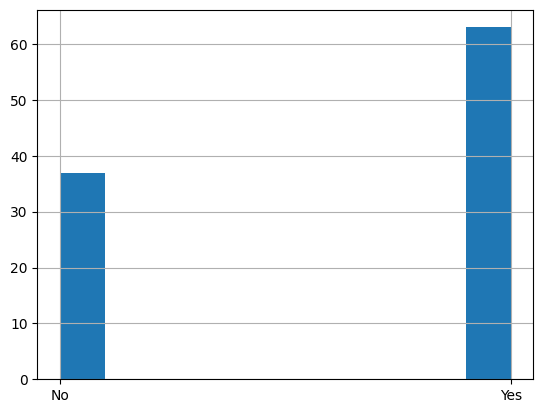

In [9]:
df_test["prediction"].hist()

In [10]:
import pandas as pd
from sklearn.metrics import f1_score

# Normalize violates_rule to Yes/No
df_test["violates_rule"] = df_test["violates_rule"].map({True: "Yes", False: "No", "Yes": "Yes", "No": "No"})

# Compute F1 score (convert Yes/No to 1/0)
y_true = df_test["violates_rule"].map({"Yes": 1, "No": 0})
y_pred = df_test["prediction"].map({"Yes": 1, "No": 0})

f1 = f1_score(y_true, y_pred)

print("F1-score:", f1)


F1-score: 0.8813559322033898


<Axes: >

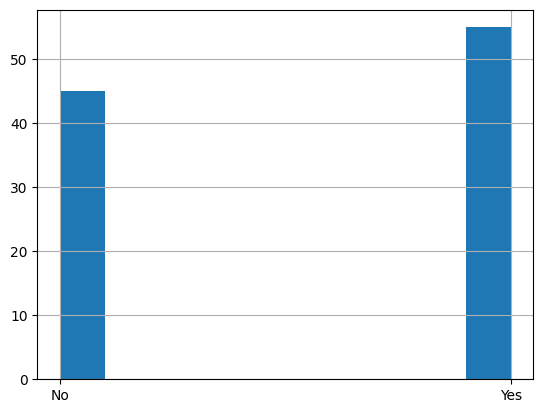

In [11]:
df_test["violates_rule"].hist()